# 🌽 Klasifikasi Jenis Sayur

Proyek ini bertujuan untuk membangun model *machine learning* yang dapat mengklasifikasikan 15 jenis sayuran berbeda berdasarkan gambar. Model yang akan digunakan adalah model machine learning klasik, bukan *deep learning*, sesuai dengan ketentuan proyek.

## 📊 Informasi Dataset

Dataset yang digunakan adalah [Vegetable Image Dataset](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset).

1.  **Ukuran File Total:** 571.74 MB.
2.  **Total Citra:** 21,000.
3.  **Total Label / Kelas:** 15
    - Bean, Bitter Gourd, Bottle Gourd, Brinjal, Broccoli, Cabbage, Capsicum, Carrot, Cauliflower, Cucumber, Papaya, Potato, Pumpkin, Radish, and Tomato.
4.  **Struktur Data:**
    - **Training:** 15,000 gambar (1,000 per kelas)
    - **Test:** 3,000 gambar (200 per kelas)
    - **Validation:** 3,000 gambar (200 per kelas)

## ⛑️ Ketentuan Proyek

1.  **Pra Pengolahan Data:** Melakukan *resizing* (scaling), dan konversi citra.
2.  **Ekstraksi Fitur:** Menggunakan metode manual seperti *Color Histogram* dan *Local Binary Pattern (LBP)* untuk mengekstrak fitur dari citra. Reduksi dimensi dengan PCA juga akan dilakukan.
3.  **Pembuatan Data Latih dan Uji:** Melakukan *splitting* pada data latih asli (15k data) dengan rasio yang ditentukan.
4.  **Pembuatan Model:** Menggunakan model klasifikasi klasik (contoh: Support Vector Machine) dan melakukan *hyperparameter tuning*.
5.  **Evaluasi Model:** Menganalisis performa model menggunakan metrik akurasi, presisi, *recall*, F1-score, dan menyajikannya dalam bentuk grafik (*confusion matrix*).

### Langkah 0: Setup Environment

Pertama, kita akan mengimpor semua pustaka (*library*) yang dibutuhkan. Jika Anda menggunakan Google Colab, Anda mungkin perlu mengunggah dataset atau menghubungkannya dari Kaggle.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'vegetable-image-dataset' dataset.
Path to dataset files: /kaggle/input/vegetable-image-dataset


### Langkah 1 & 2: Pra Pengolahan Data dan Ekstraksi Fitur

Kita akan membuat fungsi untuk memuat gambar, melakukan pra-pengolahan, dan mengekstrak fitur secara bersamaan. Proses ini akan diterapkan pada setiap gambar.

**Pra-pengolahan:**
1.  **Resizing:** Menyamakan ukuran semua gambar menjadi 64x64 piksel untuk konsistensi.
2.  **Konversi Grayscale:** Mengubah gambar menjadi *grayscale* untuk menyederhanakan ekstraksi fitur tekstur (LBP).

**Ekstraksi Fitur:**
1.  **Color Histogram:** Menghitung histogram warna dari gambar asli (BGR) untuk menangkap distribusi warna. Fitur ini sangat berguna karena sayuran seringkali dapat dibedakan berdasarkan warnanya.
2.  **Local Binary Pattern (LBP):** Menghitung fitur tekstur dari gambar *grayscale*. LBP efektif dalam mengenali pola seperti guratan, bintik, atau permukaan yang berbeda pada sayuran.

In [4]:
def extract_features(image_path, image_size=64):
    # Baca gambar
    img = cv2.imread(image_path)

    # --- Pra-pengolahan ---
    # 1. Resizing
    img_resized = cv2.resize(img, (image_size, image_size))

    # 2. Konversi ke Grayscale untuk LBP
    gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # --- Ekstraksi Fitur ---
    # 1. Color Histogram (dari gambar BGR yang sudah di-resize)
    hist_b = cv2.calcHist([img_resized], [0], None, [32], [0, 256])
    hist_g = cv2.calcHist([img_resized], [1], None, [32], [0, 256])
    hist_r = cv2.calcHist([img_resized], [2], None, [32], [0, 256])
    color_hist = np.concatenate((hist_b, hist_g, hist_r)).flatten()

    # 2. Local Binary Pattern (LBP) untuk tekstur
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_img, n_points, radius, 'uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6) # Normalisasi

    # Gabungkan semua fitur menjadi satu vektor
    combined_features = np.concatenate((color_hist, lbp_hist))

    return combined_features

def load_dataset(dataset_path):
    features = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        print(f"Processing class: {class_name}")
        for image_name in tqdm(os.listdir(class_dir)):
            image_path = os.path.join(class_dir, image_name)

            # Ekstrak fitur dari setiap gambar
            try:
                feature_vector = extract_features(image_path)
                features.append(feature_vector)
                labels.append(class_name)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return np.array(features), np.array(labels), class_names

# Tentukan path ke dataset Anda
# Ganti path ini sesuai dengan lokasi dataset di sistem Anda
TRAIN_PATH = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train'

#### Memuat Data Latih

Sekarang kita akan memuat data dari direktori `train` (15k gambar). Proses ini mungkin memakan waktu beberapa menit tergantung pada kecepatan komputer Anda.

In [5]:
X, y, class_names = load_dataset(TRAIN_PATH)
print(f"\nData loaded successfully!")
print(f"Total features extracted: {X.shape[0]}")
print(f"Feature vector size: {X.shape[1]}")

Processing class: Bean


100%|██████████| 1000/1000 [00:12<00:00, 82.18it/s]


Processing class: Bitter_Gourd


100%|██████████| 1000/1000 [00:11<00:00, 84.06it/s]


Processing class: Bottle_Gourd


100%|██████████| 1000/1000 [00:11<00:00, 90.18it/s]


Processing class: Brinjal


100%|██████████| 1000/1000 [00:12<00:00, 79.06it/s]


Processing class: Broccoli


100%|██████████| 1000/1000 [00:12<00:00, 80.34it/s]


Processing class: Cabbage


100%|██████████| 1000/1000 [00:12<00:00, 82.34it/s]


Processing class: Capsicum


100%|██████████| 1000/1000 [00:10<00:00, 97.98it/s]


Processing class: Carrot


100%|██████████| 1000/1000 [00:11<00:00, 89.79it/s]


Processing class: Cauliflower


100%|██████████| 1000/1000 [00:12<00:00, 79.70it/s]


Processing class: Cucumber


100%|██████████| 1000/1000 [00:12<00:00, 81.15it/s]


Processing class: Papaya


100%|██████████| 1000/1000 [00:10<00:00, 93.55it/s]


Processing class: Potato


100%|██████████| 1000/1000 [00:10<00:00, 92.01it/s]


Processing class: Pumpkin


100%|██████████| 1000/1000 [00:12<00:00, 78.67it/s]


Processing class: Radish


100%|██████████| 1000/1000 [00:11<00:00, 85.61it/s]


Processing class: Tomato


100%|██████████| 1000/1000 [00:10<00:00, 93.26it/s]



Data loaded successfully!
Total features extracted: 15000
Feature vector size: 122


### Langkah 3: Pembuatan Data Latih dan Uji

Data yang telah diekstraksi fiturnya akan dibagi menjadi data latih dan data uji. Sesuai ketentuan, kita akan menggunakan rasio 80:20.

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Normalisasi fitur (penting untuk SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# (Opsional) Reduksi Dimensi dengan PCA
print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=100) # Mengambil 100 komponen utama (misalnya)
X_pca = pca.fit_transform(X_scaled)
print(f"Dimension reduced from {X_scaled.shape[1]} to {X_pca.shape[1]}")

# Split data: 80% untuk training, 20% untuk testing
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Applying PCA for dimensionality reduction...
Dimension reduced from 122 to 100
Training data shape: (12000, 100)
Testing data shape: (3000, 100)


### Langkah 4: Pembuatan Model (Support Vector Machine)

Kita akan menggunakan **Support Vector Classifier (SVC)**. Untuk mendapatkan performa terbaik, kita akan mencari *hyperparameter* optimal menggunakan `GridSearchCV`.

In [8]:
print("Starting Hyperparameter Tuning with GridSearchCV...")

# Tentukan parameter grid untuk dicari
# Untuk menghemat waktu, kita hanya mencari beberapa nilai. Untuk hasil lebih baik, perluas rentang pencarian.
param_grid = {
    'C': [1, 10, 100],          # Regularization parameter
    'gamma': [0.01, 0.001], # Kernel coefficient
    'kernel': ['rbf']           # Kernel type
}

# Buat model GridSearchCV
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3, n_jobs=-1)

# Latih model
grid.fit(X_train, y_train)

# Tampilkan parameter terbaik
print(f"\nBest parameters found: {grid.best_params_}")

# Model terbaik yang sudah dilatih
best_model = grid.best_estimator_

Starting Hyperparameter Tuning with GridSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters found: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


### Langkah 5: Evaluasi Model

Sekarang kita evaluasi model terbaik pada data uji (`X_test`) yang belum pernah dilihat sebelumnya.

In [9]:
# Prediksi pada data uji
y_pred = best_model.predict(X_test)

# Tampilkan laporan klasifikasi (Akurasi, Presisi, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {accuracy * 100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

        Bean       0.98      0.98      0.98       200
Bitter_Gourd       0.99      0.99      0.99       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       0.99      0.98      0.99       200
    Broccoli       0.97      0.98      0.97       200
     Cabbage       0.98      0.97      0.98       200
    Capsicum       0.98      0.98      0.98       200
      Carrot       0.99      1.00      0.99       200
 Cauliflower       0.97      0.96      0.96       200
    Cucumber       0.99      0.99      0.99       200
      Papaya       0.99      0.96      0.98       200
      Potato       0.97      0.99      0.98       200
     Pumpkin       0.95      0.93      0.94       200
      Radish       1.00      0.99      0.99       200
      Tomato       0.94      0.96      0.95       200

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
wei

#### Visualisasi Hasil: Confusion Matrix

Confusion matrix membantu kita melihat kelas mana yang sering salah diklasifikasikan oleh model.

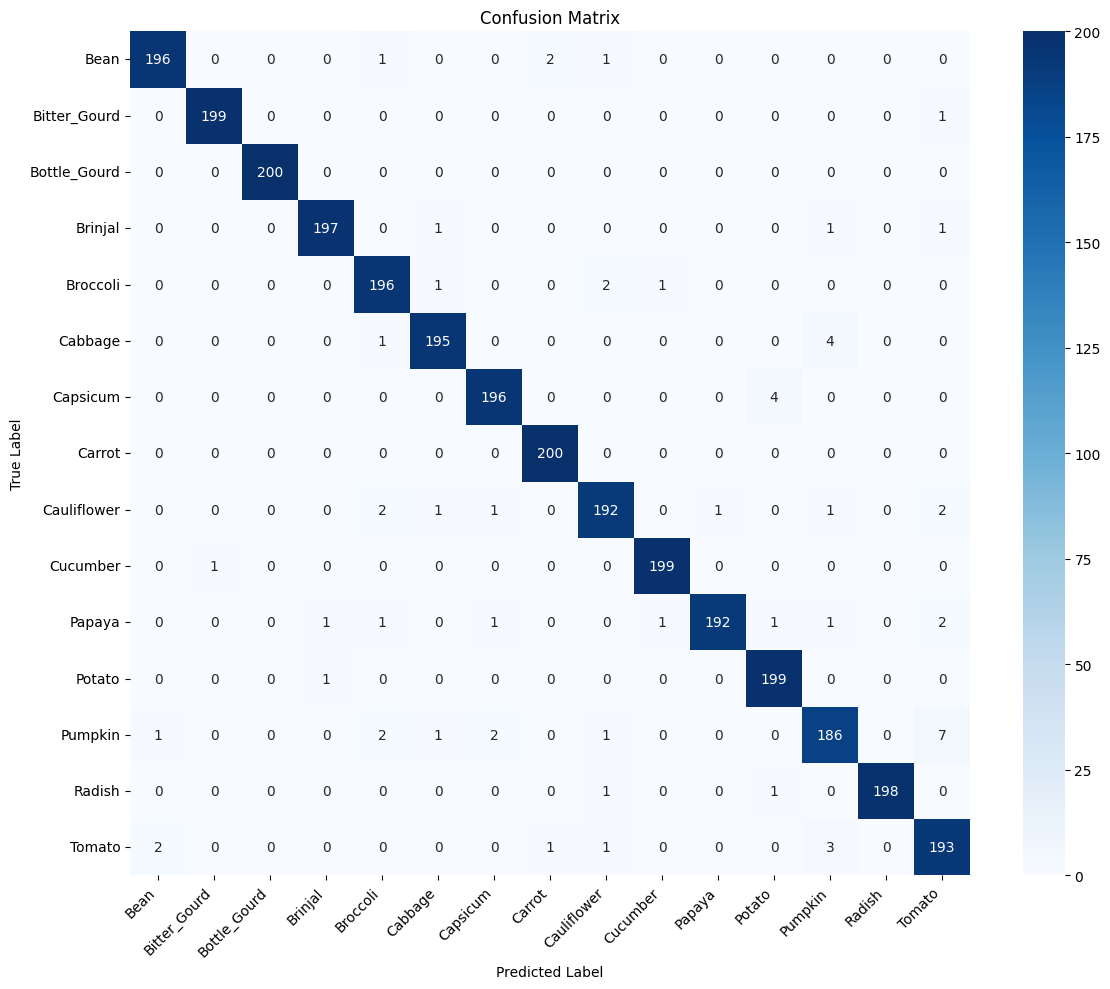

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=class_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Menyimpan Model

Setelah model dilatih, kita dapat menyimpannya ke dalam file agar dapat digunakan kembali tanpa perlu melatih ulang.

In [11]:
import joblib

# Simpan model, scaler, dan pca
joblib.dump(best_model, 'vegetable_classifier_svc.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(class_names, 'class_names.pkl')

print("Model, scaler, PCA, and class names have been saved successfully.")

Model, scaler, PCA, and class names have been saved successfully.


Model, scaler, PCA, and class names loaded successfully.

Menguji model dengan gambar: /kaggle/input/vegetable-image-dataset/Vegetable Images/test/Tomato/1075.jpg
Prediksi Model: Tomato
Label Sebenarnya: Tomato


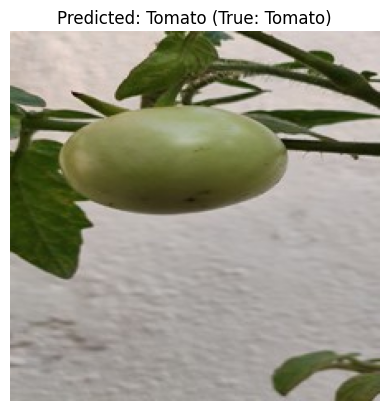

In [16]:
import joblib
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

# --- 1. Muat Model dan Komponen Lainnya ---
# Pastikan Anda telah menjalankan cell 'save-model-code' sebelumnya

best_model = joblib.load('vegetable_classifier_svc.pkl')
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')
class_names = joblib.load('class_names.pkl')

print("Model, scaler, PCA, and class names loaded successfully.")

# --- 2. Buat Fungsi Prediksi untuk Gambar Baru ---
def predict_single_image(image_path, image_size=64):
    # Re-use the feature extraction logic from the original `extract_features` function
    # Baca gambar
    img = cv2.imread(image_path)

    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # --- Pra-pengolahan ---
    # 1. Resizing
    img_resized = cv2.resize(img, (image_size, image_size))

    # 2. Konversi ke Grayscale untuk LBP
    gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # --- Ekstraksi Fitur ---
    # 1. Color Histogram (dari gambar BGR yang sudah di-resize)
    hist_b = cv2.calcHist([img_resized], [0], None, [32], [0, 256])
    hist_g = cv2.calcHist([img_resized], [1], None, [32], [0, 256])
    hist_r = cv2.calcHist([img_resized], [2], None, [32], [0, 256])
    color_hist = np.concatenate((hist_b, hist_g, hist_r)).flatten()

    # 2. Local Binary Pattern (LBP) untuk tekstur
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_img, n_points, radius, 'uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6) # Normalisasi

    # Gabungkan semua fitur menjadi satu vektor
    combined_features = np.concatenate((color_hist, lbp_hist))

    # Reshape untuk satu sampel
    features_reshaped = combined_features.reshape(1, -1)

    # Skala fitur menggunakan scaler yang telah dilatih
    features_scaled = scaler.transform(features_reshaped)

    # Reduksi dimensi menggunakan PCA yang telah dilatih
    features_pca = pca.transform(features_scaled)

    # Lakukan prediksi
    prediction = best_model.predict(features_pca)

    return prediction[0]

# --- 3. Uji dengan Contoh Gambar ---
# Tentukan path ke direktori test
TEST_PATH = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test'

# Pilih satu gambar acak dari sub-direktori 'Bean' sebagai contoh
# Anda bisa mengganti 'Bean' dengan kelas lain atau memilih gambar lain
example_class = 'Tomato' # Contoh: Mengambil gambar kacang
example_image_dir = os.path.join(TEST_PATH, example_class)

# Ambil gambar pertama dari direktori contoh (jika ada)
example_image_name = os.listdir(example_image_dir)[0]
example_image_path = os.path.join(example_image_dir, example_image_name)

print(f"\nMenguji model dengan gambar: {example_image_path}")

try:
    predicted_label = predict_single_image(example_image_path)
    print(f"Prediksi Model: {predicted_label}")
    print(f"Label Sebenarnya: {example_class}")

    # Anda juga bisa menampilkan gambar aslinya
    img_display = cv2.imread(example_image_path)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB) # Konversi ke RGB untuk matplotlib
    plt.imshow(img_display)
    plt.title(f"Predicted: {predicted_label} (True: {example_class})")
    plt.axis('off')
    plt.show()
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred during prediction: {e}")